## Predicting Airbnb popularity

A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

In [22]:
#Importing libraries needed
import pandas as pd
import numpy as np 
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RandomizedSearchCV
import altair as alt
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import loguniform
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm.sklearn import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV
import shap
import eli5
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('data_server')

#### Thoughts on the problem and the dataset

The data set contains properties listed on Airbnb in New York in 2019, it is build of an identifier for each record (`id`) and 15 attributes associated with each property, of these attributes 6 are categorical and 9 are numeric (both discrete and continuous). The attributes contain information about the host, geographic location, property type, price, restrictions, and reviews. Additionally, the size of the data frame is good, there are almost 49 thousand records (before processing).

The objective of the model is to predict the popularity of an accommodation using the objective variable `reviews_per_month`. Our target variable is a good proxy for popularity since Airbnb has mechanisms that encourage users to write reviews on the platform, and, as a consequence, reviews are a core factor when deciding on an accommodation among all the options available.

In [23]:
# Reading the data and displaying the first few rows
airbnb_data = pd.read_csv('../data/AB_NYC_2019.csv')
airbnb_data.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


#### Preliminary preprocessing

The `reviews_per_month` column has about 10 thousand null values, since this is the target variable we will remove those rows.

In [24]:
# Glimpse of column types and null values
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [25]:
# Data frame quick summary statistics
airbnb_data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [26]:
airbnb_data = airbnb_data.dropna(axis=0)
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38821 entries, 0 to 48852
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              38821 non-null  int64  
 1   name                            38821 non-null  object 
 2   host_id                         38821 non-null  int64  
 3   host_name                       38821 non-null  object 
 4   neighbourhood_group             38821 non-null  object 
 5   neighbourhood                   38821 non-null  object 
 6   latitude                        38821 non-null  float64
 7   longitude                       38821 non-null  float64
 8   room_type                       38821 non-null  object 
 9   price                           38821 non-null  int64  
 10  minimum_nights                  38821 non-null  int64  
 11  number_of_reviews               38821 non-null  int64  
 12  last_review                     

In [27]:
# Data split, selected a 70-30 proportion since my laptop is not that capable, hence I'm trying this to reduce fit time a bit. 
train_df, test_df = train_test_split(airbnb_data, test_size=0.3, random_state=123)

#### Plots for meaningful categorical variables

The following graph shows the frequencies for each of the levels of the `neighbourhood_group` categorical variable, this to better understand how properties are distributed in New York neighborhoods. Manhattan being the neighborhood with the largest number of accommodations.

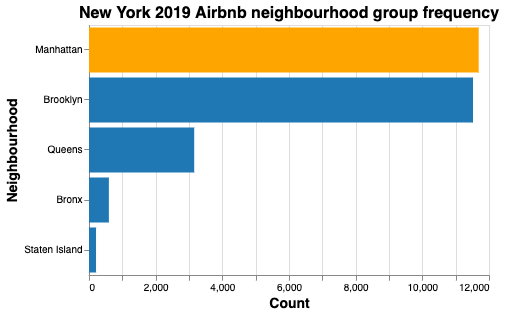

In [28]:
neighbourhood_data = train_df.copy()
neighbourhood_data.loc[:,'highlight'] = False
neighbourhood_data.loc[neighbourhood_data['neighbourhood_group'] == 'Manhattan', 'highlight'] = True

neighbourhood_plot = alt.Chart(neighbourhood_data).mark_bar().encode(
    x=alt.X('count()', title='Count'),
    y=alt.Y('neighbourhood_group', title='Neighbourhood', sort='-x'), 
    color=alt.Color('highlight', legend=None, scale=alt.Scale(range=['#1f77b4', 'orange']))).properties(
    title='New York 2019 Airbnb neighbourhood group frequency',height=250, width=400).configure_axis(
    titleFontSize=14
    ).configure_title(
    fontSize=16
    )
neighbourhood_plot

The following graph shows the `room_type` frequencies, this to better understand the levels of this categorical variable. Most of the properties are entire homes / apartments.

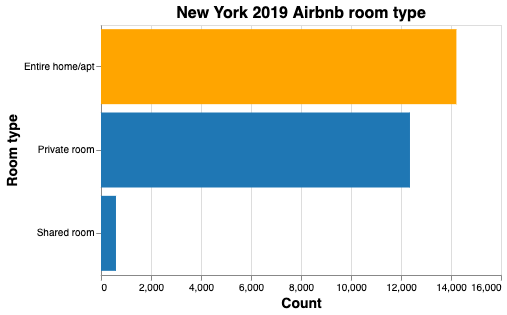

In [29]:
room_type_data = train_df.copy()
room_type_data['highlight'] = False
room_type_data.loc[room_type_data['room_type'] == 'Entire home/apt', 'highlight'] = True

neighbourhood_plot = alt.Chart(room_type_data).mark_bar().encode(
    x=alt.X('count()', title='Count'),
    y=alt.Y('room_type', title='Room type', sort='-x'), 
    color=alt.Color('highlight', legend=None, scale=alt.Scale(range=['#1f77b4', 'orange']))).properties(
    title='New York 2019 Airbnb room type',height=250, width=400).configure_axis(
    titleFontSize=14
    ).configure_title(
    fontSize=16
    )
neighbourhood_plot

#### Distribution plots for meaningful numerical variables

Below is the price distribution by type of room. It can be seen that the price spread for houses and apartments is higher than that for private and shared rooms.

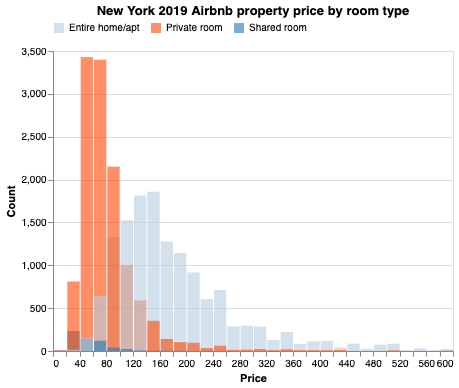

In [30]:
price_dist = alt.Chart(room_type_data).mark_bar(opacity=0.6, clip=True).encode(
    alt.X('price', bin=alt.Bin(maxbins=600), scale=alt.Scale(domain=(0, 600)), title = 'Price'),
    alt.Y('count()', title = 'Count', stack=False),
    color=alt.Color('room_type', 
                    scale=alt.Scale(range=['#b6cde1', 'orangered', '#1f77b4']),
                    legend=alt.Legend(orient="top", title=None))
    ).properties(
    height=300, 
    width=400, 
    title="New York 2019 Airbnb property price by room type"
    )
price_dist

The following graph shows our target variable `monthly reviews` distribution, cropped to from 0 to 10 reviews per month since most of the observations fall within this range. 

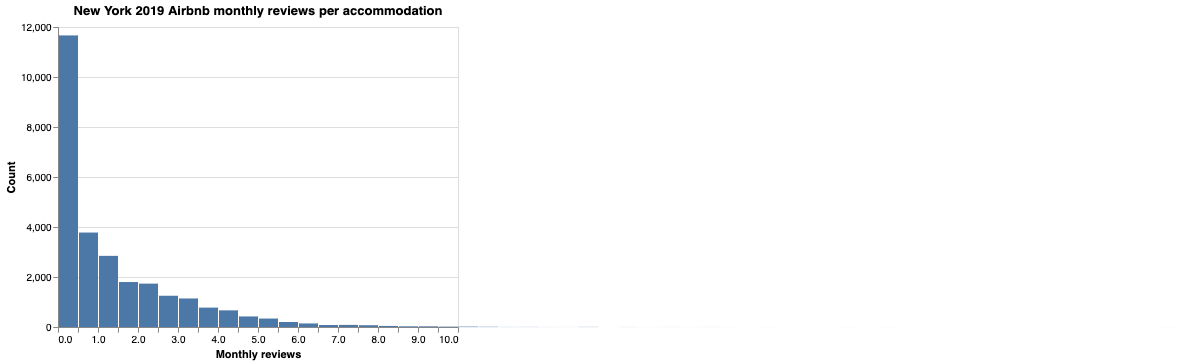

In [31]:
count_dist = alt.Chart(room_type_data).mark_bar().encode(
    alt.X('reviews_per_month', bin=alt.Bin(maxbins=100), scale=alt.Scale(domain=(0, 10)), title = 'Monthly reviews'),
    alt.Y('count()', title = 'Count', stack=False),
    ).properties(
    height=300, 
    width=400, 
    title="New York 2019 Airbnb monthly reviews per accommodation"
    )
count_dist

#### Pairwise comparison to identify variable correlations

Lastly, the following matrix shows the correlation for some of our numerical variables, there is not a variable that shows a strong linear correlation with the objective variable (apart form number of reviews).

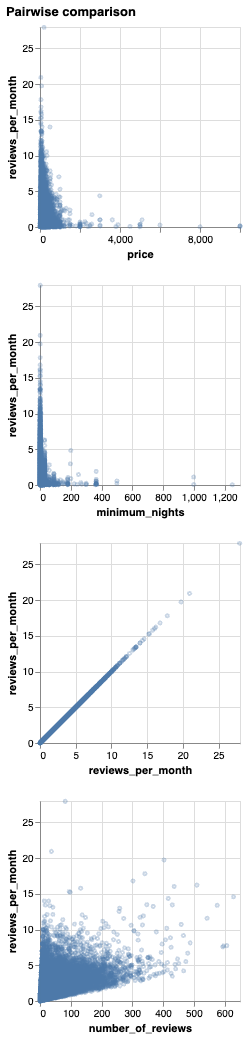

In [32]:
pair_chart = alt.Chart(room_type_data).mark_point(opacity=0.3, size=10).encode(
     alt.X(alt.repeat('row'), type='quantitative'),
     alt.Y(alt.repeat('column'), type='quantitative')
).properties(
    width=200,
    height=200
).repeat(
    column=['reviews_per_month'],
    row=['price', 'minimum_nights', 'reviews_per_month', 'number_of_reviews']
).properties(
    title="Pairwise comparison"
    )
pair_chart

#### Summary Statistics of meaningful columns

The following table shows the summary statistics for the numerical variables. This to have a quick overview of variable values. 

In [13]:
train_df[['price','minimum_nights', 'number_of_reviews', 
          'reviews_per_month', 'calculated_host_listings_count',
         'availability_365']].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,27174.000000,27174.000000,27174.000000,27174.000000,27174.000000,27174.000000
mean,142.572054,5.978950,29.492714,1.372901,5.148672,114.698867
std,197.372055,19.249904,48.617350,1.670782,26.179356,129.534040
min,0.000000,1.000000,1.000000,0.010000,1.000000,0.000000
25%,69.000000,1.000000,3.000000,0.190000,1.000000,0.000000
50%,102.000000,2.000000,9.000000,0.710000,1.000000,55.000000
75%,170.000000,4.000000,34.000000,2.000000,2.000000,229.000000
max,10000.000000,1250.000000,629.000000,27.950000,327.000000,365.000000


#### Summarizing initial observations

At first glance, there are no variables that have a very strong correlation with the objective variable (beyond the number of reviews), however, the data set is very rich since we have attributes of the host, characteristics of the place and the geographical location. Therefore, the expectation is that the interactions between these variables can provide good predictive power to the machine learning model.

#### Pick appropriate metric/metrics for assessment

I decided to use $R^2$ sklearn default scoring metric.

In [14]:
# Date to year to treat this variable as categorical.
train_df["last_review"] = pd.to_datetime(train_df["last_review"])
train_df['last_review'] = train_df['last_review'].dt.strftime("%Y")
test_df["last_review"] = pd.to_datetime(test_df["last_review"])
test_df['last_review'] = test_df['last_review'].dt.strftime("%Y")

#### Identifying transformations and building column transformer

In [15]:
#X and y split
X_train, y_train = train_df.drop(columns=["reviews_per_month"]), train_df["reviews_per_month"]
X_test, y_test = test_df.drop(columns=["reviews_per_month"]), test_df["reviews_per_month"]

In [16]:
#Setting up transformers
categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']
numeric_features = ['latitude', 'longitude', 'price', 
                      'minimum_nights', 'number_of_reviews', 
                      'calculated_host_listings_count', 'availability_365'] 
drop_features = ['id', 'host_id', 'host_name', 'name']

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

# Building preprocessor pipeline
preprocessor = make_column_transformer(
    (
        categorical_transformer,
        categorical_features
    ),
    (
        numeric_transformer,
        numeric_features
    ),
    (
        "drop", drop_features
    )
)

#### Training Dummy Regressor base model 

In [17]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [18]:
# Fitting dummy regressor baseline model 
results_dict = {} 
dummy = DummyRegressor()
pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.020 (+/- 0.003),0.005 (+/- 0.000),-0.000 (+/- 0.001),0.000 (+/- 0.000)


#### First linear model - Ridge

In [19]:
# Cross validation for Ridge model
ridge = Ridge(random_state=123)
pipe_ridge = make_pipeline(preprocessor, ridge)
results_dict["ridge"] = mean_std_cross_val_scores(
    pipe_ridge, X_train, y_train, cv=5, return_train_score=True
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.020 (+/- 0.003),0.005 (+/- 0.000),-0.000 (+/- 0.001),0.000 (+/- 0.000)
ridge,0.041 (+/- 0.007),0.006 (+/- 0.000),0.449 (+/- 0.016),0.461 (+/- 0.004)


#### Hyperparameter tunning

In [20]:
# Alpha Hyper parameter tunning for Ridge model 
param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

pipe_rid = make_pipeline(preprocessor, Ridge(random_state=123))

search_rand = RandomizedSearchCV(
    pipe_rid, param_dist, return_train_score=True, n_jobs=-1, n_iter=20, random_state=123
)
search_rand.fit(X_train, y_train)
best_params = search_rand.best_params_['ridge__alpha']
best_score = search_rand.best_score_
best_params, best_score

(20.740241962891858, 0.4509056866278026)

#### Linear model Ridge with for optimized alpha

In [21]:
# Reporting validation scores for optimized model
ridge_opt = Ridge(alpha=best_params)
pipe_ridge_opt = make_pipeline(preprocessor, ridge_opt)
results_dict["ridge_opt"] = mean_std_cross_val_scores(
    pipe_ridge_opt, X_train, y_train, cv=5, return_train_score=True
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.020 (+/- 0.003),0.005 (+/- 0.000),-0.000 (+/- 0.001),0.000 (+/- 0.000)
ridge,0.041 (+/- 0.007),0.006 (+/- 0.000),0.449 (+/- 0.016),0.461 (+/- 0.004)
ridge_opt,0.029 (+/- 0.003),0.005 (+/- 0.000),0.451 (+/- 0.015),0.458 (+/- 0.004)


#### Results summary

The first linear model has an acceptable cross-validation score but with space for improvement, in addition, both training and validation scores improved but marginally. Regarding the fit time, the model fits fast considering the size of our data set.

#### Building KNeighborsRegressor, RBF SVR and Gradient Boosting

In [22]:
# Passing all three models to cross validation
models = {
    "KNN": KNeighborsRegressor(),
    "RBF SVR": SVR(),
    "Gradient Boosting":GradientBoostingRegressor(random_state=123)
}
for model_name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[model_name] = mean_std_cross_val_scores(pipe,
                                                         X_train, 
                                                         y_train, 
                                                         return_train_score=True)

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.020 (+/- 0.003),0.005 (+/- 0.000),-0.000 (+/- 0.001),0.000 (+/- 0.000)
ridge,0.041 (+/- 0.007),0.006 (+/- 0.000),0.449 (+/- 0.016),0.461 (+/- 0.004)
ridge_opt,0.029 (+/- 0.003),0.005 (+/- 0.000),0.451 (+/- 0.015),0.458 (+/- 0.004)
KNN,0.019 (+/- 0.001),3.692 (+/- 0.199),0.435 (+/- 0.013),0.627 (+/- 0.004)
RBF SVR,11.659 (+/- 0.070),1.692 (+/- 0.005),0.488 (+/- 0.011),0.509 (+/- 0.002)
Gradient Boosting,2.265 (+/- 0.011),0.011 (+/- 0.001),0.565 (+/- 0.010),0.592 (+/- 0.003)


#### Building XGBoost and LGBoostingMachine

As a curiosity exercise, I will try addition gradient boosting machine frameworks to see how they perform.

In [23]:
# Passing gradient boosting machines to cross validation
models = {
    "LGBMR": LGBMRegressor(random_state=123),
    "XGBR": XGBRegressor(random_state=123),
}
for model_name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[model_name] = mean_std_cross_val_scores(pipe,
                                                         X_train, 
                                                         y_train, 
                                                         return_train_score=True)

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.020 (+/- 0.003),0.005 (+/- 0.000),-0.000 (+/- 0.001),0.000 (+/- 0.000)
ridge,0.041 (+/- 0.007),0.006 (+/- 0.000),0.449 (+/- 0.016),0.461 (+/- 0.004)
ridge_opt,0.029 (+/- 0.003),0.005 (+/- 0.000),0.451 (+/- 0.015),0.458 (+/- 0.004)
KNN,0.019 (+/- 0.001),3.692 (+/- 0.199),0.435 (+/- 0.013),0.627 (+/- 0.004)
RBF SVR,11.659 (+/- 0.070),1.692 (+/- 0.005),0.488 (+/- 0.011),0.509 (+/- 0.002)
Gradient Boosting,2.265 (+/- 0.011),0.011 (+/- 0.001),0.565 (+/- 0.010),0.592 (+/- 0.003)
LGBMR,0.294 (+/- 0.013),0.011 (+/- 0.000),0.597 (+/- 0.009),0.682 (+/- 0.002)
XGBR,0.527 (+/- 0.004),0.009 (+/- 0.000),0.585 (+/- 0.010),0.738 (+/- 0.003)


#### Summarizing results

Light Gradient Boosting Machine Regressor shows the best performance among all the models, actually the three gradient boosting models performances are similar, with the difference that both `LGBMR` and `XGBR` seem to be operating in the overfitting area. Regarding training times, `LGBMR` has the advantage among the Boosting Machines while `RBF SVR` is by far the one with the highest fit time.

Since the Light Gradient Boosting Machine Regressor has the best validation score and the fastest fit time I'll use that as my model for the following exercises, hoping to alleviate the overfitting.

#### Feature selection using RFECV

In [24]:
# Building pipeline using RFECV
pipe_rfe_boost = make_pipeline(preprocessor, 
                                 RFECV(Ridge(random_state=123), cv=10), 
                                 LGBMRegressor(random_state=123))

results_dict["RFECV"] = mean_std_cross_val_scores(pipe_rfe_boost, 
                                                  X_train, 
                                                  y_train, 
                                                  return_train_score=True)

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.020 (+/- 0.003),0.005 (+/- 0.000),-0.000 (+/- 0.001),0.000 (+/- 0.000)
ridge,0.041 (+/- 0.007),0.006 (+/- 0.000),0.449 (+/- 0.016),0.461 (+/- 0.004)
ridge_opt,0.029 (+/- 0.003),0.005 (+/- 0.000),0.451 (+/- 0.015),0.458 (+/- 0.004)
KNN,0.019 (+/- 0.001),3.692 (+/- 0.199),0.435 (+/- 0.013),0.627 (+/- 0.004)
RBF SVR,11.659 (+/- 0.070),1.692 (+/- 0.005),0.488 (+/- 0.011),0.509 (+/- 0.002)
Gradient Boosting,2.265 (+/- 0.011),0.011 (+/- 0.001),0.565 (+/- 0.010),0.592 (+/- 0.003)
LGBMR,0.294 (+/- 0.013),0.011 (+/- 0.000),0.597 (+/- 0.009),0.682 (+/- 0.002)
XGBR,0.527 (+/- 0.004),0.009 (+/- 0.000),0.585 (+/- 0.010),0.738 (+/- 0.003)
RFECV,24.109 (+/- 0.866),0.013 (+/- 0.002),0.587 (+/- 0.013),0.671 (+/- 0.007)


#### Do the results improve with feature selection?

`RFECV` validation score is similar to `LGBMR`, however, the fit time increases by a huge margin, given the computational resources I have, I am going to discard this stage of my pipeline.

#### Light Gradient Boosting Machine Regressor hyperparameter optimization

In [25]:
#Building parameters and ranges for the RandomizedSearchCV
param_dist = {
  #  'lgbmregressor__learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
    'lgbmregressor__n_estimators': range(1,200,1),
    'lgbmregressor__max_depth': [2, 3, 4, 5, 7, 8, 9, 10],
   # 'lgbmregressor__subsample': [i/10.0 for i in range(1,10)],
    #'lgbmregressor__colsample_bytree': [i/10.0 for i in range(1,10)], 
}

# Testing 200 random hyperparameter combinations with RandomizedSearchCV
pipe = make_pipeline(preprocessor, LGBMRegressor(random_state=123))
search_rand = RandomizedSearchCV(
    pipe, param_dist, return_train_score=True, n_jobs=-1, n_iter=200, random_state=123
)
search_rand.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['neighbourhood_group',
                                                                                'neighbourhood',
                                                                                'room_type',
                                                                                'last_review']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['latitude',
                                                                                'longitude',
                                                                                'price',
                                                                                'minimum_nights',
                                                                                'number_of_reviews',
                                                                                'calculated_host_listings_count',
                                                                                'availability_365']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['id',
                                                                                'host_id',
                                                                                'host_name',
                                                                                'name'])])),
                                             ('lgbmregressor',
                                              LGBMRegressor(random_state=123))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'lgbmregressor__max_depth': [2, 3, 4, 5,
                                                                     7, 8, 9,
                                                                     10],
                                        'lgbmregressor__n_estimators': range(1, 200)},
                   random_state=123, return_train_score=True)

In [26]:
# Building a LGBMR using the best model from the hyperparameter optimization
best_params = search_rand.best_params_
best_score = search_rand.best_score_
best_model_pipe = search_rand.best_estimator_
results_dict['LGBMR_opt'] = mean_std_cross_val_scores(best_model_pipe,
                                                     X_train, 
                                                     y_train, 
                                                     return_train_score=True)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.020 (+/- 0.003),0.005 (+/- 0.000),-0.000 (+/- 0.001),0.000 (+/- 0.000)
ridge,0.041 (+/- 0.007),0.006 (+/- 0.000),0.449 (+/- 0.016),0.461 (+/- 0.004)
ridge_opt,0.029 (+/- 0.003),0.005 (+/- 0.000),0.451 (+/- 0.015),0.458 (+/- 0.004)
KNN,0.019 (+/- 0.001),3.692 (+/- 0.199),0.435 (+/- 0.013),0.627 (+/- 0.004)
RBF SVR,11.659 (+/- 0.070),1.692 (+/- 0.005),0.488 (+/- 0.011),0.509 (+/- 0.002)
Gradient Boosting,2.265 (+/- 0.011),0.011 (+/- 0.001),0.565 (+/- 0.010),0.592 (+/- 0.003)
LGBMR,0.294 (+/- 0.013),0.011 (+/- 0.000),0.597 (+/- 0.009),0.682 (+/- 0.002)
XGBR,0.527 (+/- 0.004),0.009 (+/- 0.000),0.585 (+/- 0.010),0.738 (+/- 0.003)
RFECV,24.109 (+/- 0.866),0.013 (+/- 0.002),0.587 (+/- 0.013),0.671 (+/- 0.007)
LGBMR_opt,0.517 (+/- 0.015),0.015 (+/- 0.001),0.598 (+/- 0.010),0.715 (+/- 0.003)


#### Comments on the hyperparameter optimization.

The optimized model marginally improves the validation score, however it seems that the model still works in the overfitting area further research needed to optimize model. 

####  Feature importance using `eli5`

In [27]:
# Builing eli5 object
best_model_pipe.fit(X_train, y_train)
preprocessor.fit(X_train, y_train)
features =  preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist() + numeric_features
eli5.explain_weights(best_model_pipe.named_steps["lgbmregressor"], feature_names=features)

Weight,Feature
0.4822,number_of_reviews
0.1549,last_review_2019
0.1354,minimum_nights
0.0687,availability_365
0.0523,longitude
0.0254,latitude
0.0228,price
0.0181,calculated_host_listings_count
0.0108,neighbourhood_East Elmhurst
0.0043,room_type_Entire home/apt


#### Feature importance using `Shap Values`

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


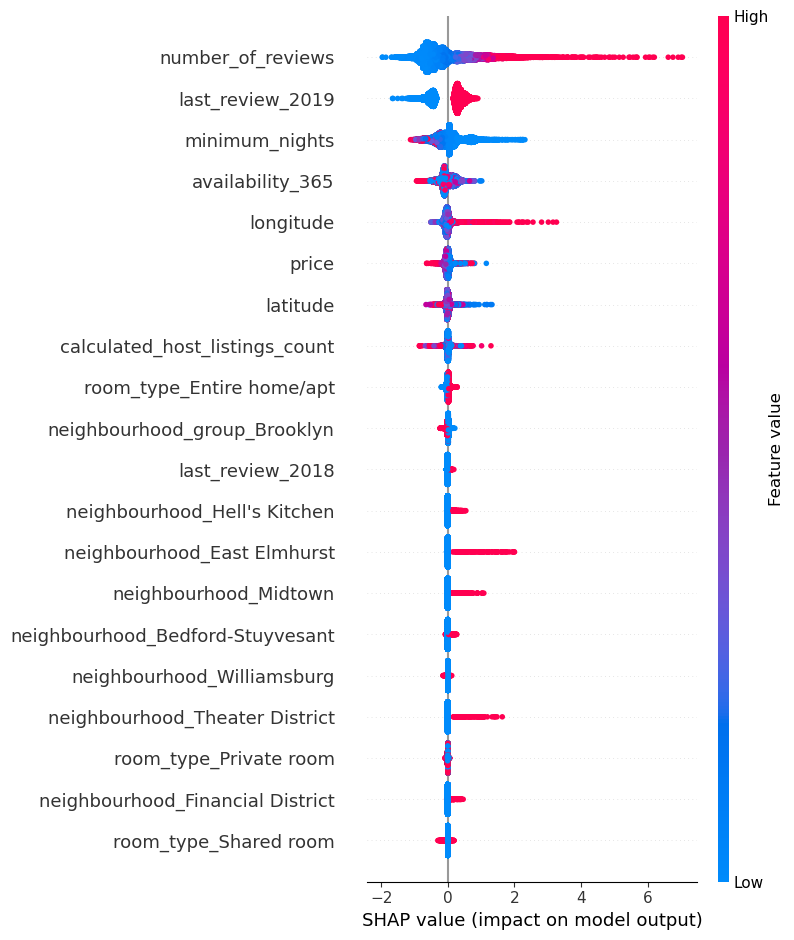

In [28]:
# Shap values input pre processing
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=features,
    index=X_train.index,
)
X_test_enc_df = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=features
)

#Building Shap values plot
lgbmr_explainer = shap.TreeExplainer(best_model_pipe.named_steps['lgbmregressor'])
train_lgbmr_shap_values = lgbmr_explainer.shap_values(X_train_enc)
shap.summary_plot(train_lgbmr_shap_values, X_train_enc)

#### Summarizing results

We can see that the top 5 variables for our model are `number_of_reviews`, `last_review_2019`, `minimum_nights`, `availability_365`, `longitude`. Since `last_review_2019` is derived from the feature engineering process, it might be worth testing some other methods to be a bit more granular, for example the difference in days between today and the last review.

The Shap Values show super interesting information, for example low values for the minimum number of nights increase the number of reviews per month and for example that the price does not seem to have such a clear contribution to increase or decrease the number of reviews per month by itself.

#### Train and Test scores report

The test score obtained is 0.567 while the final train score is 0.705, the model is consistent with the cross validation process, which indicates that the framework that was followed during the project is adequate. The results are reliable, although there seems to be room for improvement to try to decrease the validation error further by doing more research on model control and iterating on feature design and transformation.

In [29]:
# Printing train and test scores
train_score = best_model_pipe.score(X_train, y_train)
test_score = best_model_pipe.score(X_test, y_test)
print("Train score: %0.3f" % train_score)
print("Test score: %0.3f" % test_score)


Train score: 0.705
Test score: 0.567


#### Shap values force plots to visualize features contribution to specific predictions.

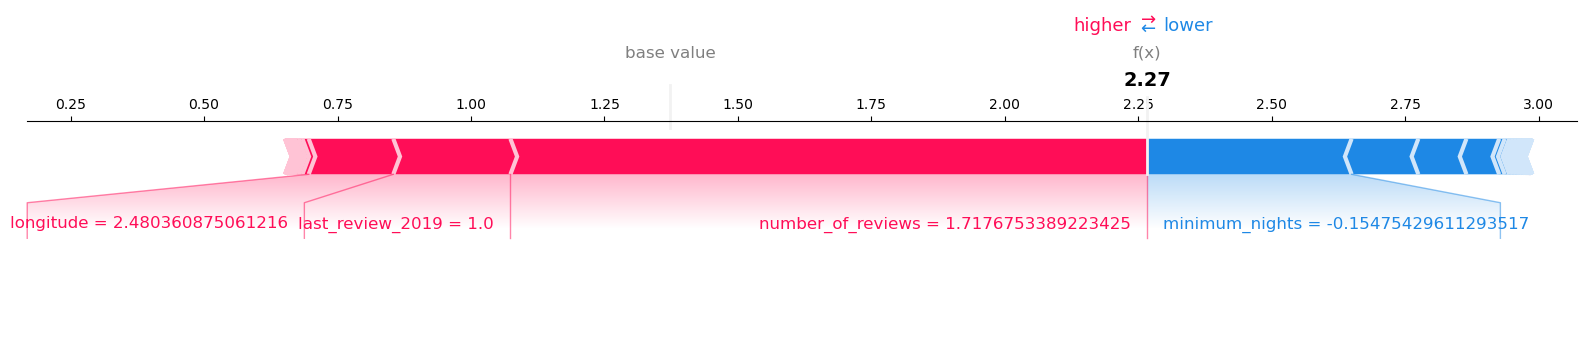

In [ ]:
# Creating force plot 1
test_lgbmr_shap_values = lgbmr_explainer.shap_values(X_test_enc_df)
shap.force_plot(lgbmr_explainer.expected_value, test_lgbmr_shap_values[-1], X_test_enc_df.iloc[-1,:], matplotlib=True)

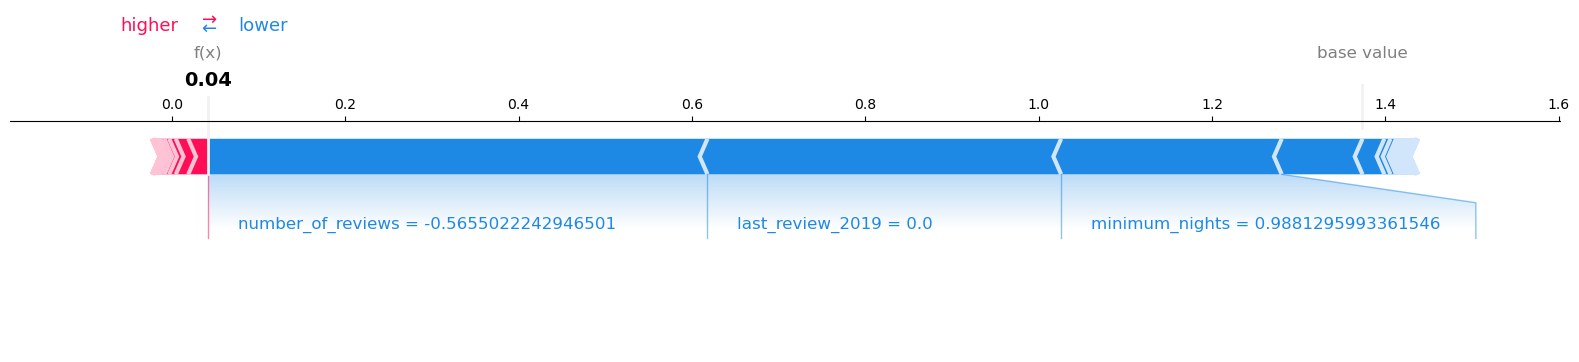

In [31]:
# Creating force plot 1
shap.force_plot(lgbmr_explainer.expected_value, test_lgbmr_shap_values[4], X_test_enc_df.iloc[4,:], matplotlib=True)

#### Results summary

In [32]:
results_df.loc[["ridge_opt", "LGBMR", "RFECV", "LGBMR_opt"],:]

,fit_time,score_time,test_score,train_score
ridge_opt,0.029 (+/- 0.003),0.005 (+/- 0.000),0.451 (+/- 0.015),0.458 (+/- 0.004)
LGBMR,0.294 (+/- 0.013),0.011 (+/- 0.000),0.597 (+/- 0.009),0.682 (+/- 0.002)
RFECV,24.109 (+/- 0.866),0.013 (+/- 0.002),0.587 (+/- 0.013),0.671 (+/- 0.007)
LGBMR_opt,0.517 (+/- 0.015),0.015 (+/- 0.001),0.598 (+/- 0.010),0.715 (+/- 0.003)


After having trained multiple models for our regression problem, the best performing model is the Light Boosting Machine Regressor, having test score of 0.567 and train score equal to 0.705, the model is consistent with the cross validation process, which indicates that framework that was followed during the project is adequate. As expected, non linear models performed better in this specific regression problem. 

As points to continue working on, I would like to iterate to improve my model and look for the fit and train scores both to increase and for them to be more similar to each other (to find the sweat spot). To do this, I would look to do a better job of feature engineering and hyper parameter optimization. For example, since the variables `latitude` and `longitude` are actually a geographic representation of a point, it is worth reviewing what feature engineering process would be suitable for these variables and applying it to see if this improves the model.